In [1]:
# کتابخانه‌های مورد نیاز
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import LSTM
from keras import layers
import keras_tuner as kt
from tqdm import tqdm

In [2]:
goog_ds = yf.download("GOOG",start="2020-01-01", end="2025-06-16", auto_adjust=False,
                    progress=False)

In [3]:
goog_ds

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,,
2020-01-02,67.964500,68.368500,68.406998,67.077499,67.077499,28132000
2020-01-03,67.630981,68.032997,68.625000,67.277199,67.392998,23728000
2020-01-06,69.298569,69.710503,69.824997,67.500000,67.500000,34646000
2020-01-07,69.255341,69.667000,70.149498,69.518997,69.897003,30054000
2020-01-08,69.801094,70.216003,70.579002,69.542000,69.603996,30560000
...,...,...,...,...,...,...
2025-06-09,177.630005,177.630005,177.914993,175.660004,175.869995,18817600
2025-06-10,180.009995,180.009995,182.445007,176.475006,177.759995,32908000


In [4]:
print(goog_ds.columns)

MultiIndex([('Adj Close', 'GOOG'),
            (    'Close', 'GOOG'),
            (     'High', 'GOOG'),
            (      'Low', 'GOOG'),
            (     'Open', 'GOOG'),
            (   'Volume', 'GOOG')],
           names=['Price', 'Ticker'])


In [5]:
df = goog_ds[["Adj Close","Open", "Close", "High", "Low"]].round(3)
df.head(10)

Price,Adj Close,Open,Close,High,Low
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2020-01-02,67.965,67.077,68.368,68.407,67.077
2020-01-03,67.631,67.393,68.033,68.625,67.277
2020-01-06,69.299,67.500,69.711,69.825,67.500
2020-01-07,69.255,69.897,69.667,70.149,69.519
2020-01-08,69.801,69.604,70.216,70.579,69.542
2020-01-09,70.572,71.029,70.992,71.367,70.513
2020-01-10,71.064,71.378,71.487,71.746,70.918
2020-01-13,71.536,71.807,71.962,72.026,71.301


<Axes: xlabel='Date'>

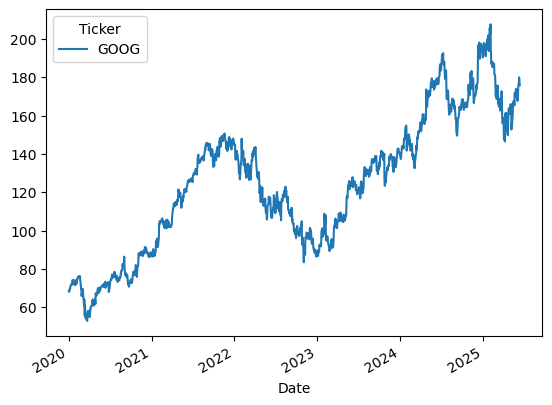

In [6]:
df.Close.plot()

In [7]:
def ts_data(df, X_steps=60, y_steps=1,
               train_range=("2020", "2022-12-31"),
               val_range=("2023", "2023-12-31"),
               test_range=("2024", "2025-06-16")):
    
    # استخراج مقاطع زمانی
    train_df = df[train_range[0]:train_range[1]].Close.values.reshape(-1, 1)
    val_df = df[val_range[0]:val_range[1]].Close.values.reshape(-1, 1)
    test_df = df[test_range[0]:test_range[1]].Close.values.reshape(-1, 1)

    # نرمال‌سازی فقط با استفاده از داده‌های train
    sc = MinMaxScaler()
    train_scaled = sc.fit_transform(train_df)

    # ساخت X_train و y_train
    X_train, y_train = [], []
    for i in range(X_steps, len(train_scaled) - y_steps + 1):
        X_train.append(train_scaled[i - X_steps:i, 0])
        y_train.append(train_scaled[i:i + y_steps, 0])
    X_train = np.array(X_train).reshape(-1, X_steps, 1)
    y_train = np.array(y_train).reshape(-1, y_steps)

    # تابع ساخت X, y برای val و test (با scale از train)
    def make_xy(input_array):
        input_full = np.concatenate([train_df[-X_steps:], input_array])
        input_scaled = sc.transform(input_full)
        X, y = [], []
        for i in range(X_steps, len(input_scaled) - y_steps + 1):
            X.append(input_scaled[i - X_steps:i, 0])
            y.append(input_scaled[i:i + y_steps, 0])
        return np.array(X).reshape(-1, X_steps, 1), np.array(y).reshape(-1, y_steps)

    # ساخت val و test
    X_val, y_val = make_xy(val_df)
    X_test, y_test = make_xy(test_df)

    return X_train, y_train, X_val, y_val, X_test, y_test, sc


In [8]:
X_train, y_train, X_val, y_val, X_test, y_test, sc = ts_data(
                                            df, X_steps=15, y_steps=3,
                                            train_range=("2020", "2022-12-31"),
                                            val_range=("2023", "2023-12-31"),
                                            test_range=("2024", "2025-06-16")
                                                                                )

In [9]:
X_train.shape

(739, 15, 1)

## مدل SimpleRNN

In [10]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import keras_tuner as kt

# کد اصلاح شده (صحیح)
def build_simple_rnn(hp):
    model = Sequential()
    num_layers = hp.Int('num_layers', 1, 3)
    
    for i in range(num_layers):
        if i == 0:
            # اضافه کردن input_shape فقط به لایه اول
            model.add(SimpleRNN(
                units=hp.Int(f'units_{i}', min_value=16, max_value=128, step=16),
                return_sequences=(i < num_layers - 1),
                input_shape=(X_train.shape[1], X_train.shape[2])
            ))
        else:
            model.add(SimpleRNN(
                units=hp.Int(f'units_{i}', min_value=16, max_value=128, step=16),
                return_sequences=(i < num_layers - 1)
            ))
            
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    return model


## مدل LSTM

In [11]:
from keras.layers import LSTM

def build_lstm(hp):
    model = Sequential()
    num_layers = hp.Int('num_layers', 1, 3)
    
    for i in range(num_layers):
        # تغییر اصلی: اضافه کردن input_shape فقط به لایه اول
        if i == 0:
            model.add(LSTM(
                units=hp.Int(f'units_{i}', min_value=16, max_value=128, step=16),
                return_sequences=(i < num_layers - 1),
                input_shape=(X_train.shape[1], X_train.shape[2])
            ))
        else:
            model.add(LSTM(
                units=hp.Int(f'units_{i}', min_value=16, max_value=128, step=16),
                return_sequences=(i < num_layers - 1)
            ))
            
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    return model


## مدل GRU

In [12]:
from keras.layers import GRU

def build_gru(hp):
    model = Sequential()
    num_layers = hp.Int('num_layers', 1, 3)
    
    for i in range(num_layers):
        # تغییر اصلی: اضافه کردن input_shape فقط به لایه اول
        if i == 0:
            model.add(GRU(
                units=hp.Int(f'units_{i}', min_value=16, max_value=128, step=16),
                return_sequences=(i < num_layers - 1),
                input_shape=(X_train.shape[1], X_train.shape[2])
            ))
        else:
            model.add(GRU(
                units=hp.Int(f'units_{i}', min_value=16, max_value=128, step=16),
                return_sequences=(i < num_layers - 1)
            ))
            
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    return model


## مدل ترکیبی LSTM+GRU

In [13]:
def build_lstm_gru(hp):
    model = Sequential()
    
    # تغییر اصلی: اضافه کردن input_shape به لایه اول (LSTM)
    model.add(LSTM(
        units=hp.Int('lstm_units', min_value=16, max_value=128, step=16),
        return_sequences=True, # باید True باشد تا به لایه GRU داده شود
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    
    model.add(GRU(
        units=hp.Int('gru_units', min_value=16, max_value=128, step=16),
        return_sequences=False # لایه آخر return_sequences=False است
    ))
    
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    return model


### اجرای Hyperparameter Tuner برای SimpleRNN، LSTM، GRU و مدل ترکیبی

In [14]:

# اجرای Tuner برای SimpleRNN
tuner_rnn = kt.Hyperband(build_simple_rnn, objective='val_mae', max_epochs=20, factor=3, directory='rnn_tuning', project_name='simple_rnn')
tuner_rnn.search(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1)
best_rnn_model = tuner_rnn.get_best_models(1)[0]
rnn_val_pred = best_rnn_model.predict(X_val)

# اجرای Tuner برای LSTM
tuner_lstm = kt.Hyperband(build_lstm, objective='val_mae', max_epochs=20, factor=3, directory='lstm_tuning', project_name='lstm_model')
tuner_lstm.search(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1)
best_lstm_model = tuner_lstm.get_best_models(1)[0]
lstm_val_pred = best_lstm_model.predict(X_val)

# اجرای Tuner برای GRU
tuner_gru = kt.Hyperband(build_gru, objective='val_mae', max_epochs=20, factor=3, directory='gru_tuning', project_name='gru_model')
tuner_gru.search(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1)
best_gru_model = tuner_gru.get_best_models(1)[0]
gru_val_pred = best_gru_model.predict(X_val)

# اجرای Tuner برای مدل ترکیبی LSTM + GRU
tuner_combined = kt.Hyperband(build_lstm_gru, objective='val_mae', max_epochs=20, factor=3, directory='combined_tuning', project_name='combined_model')
tuner_combined.search(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1)
best_combined_model = tuner_combined.get_best_models(1)[0]
combined_val_pred = best_combined_model.predict(X_val)


Trial 30 Complete [00h 00m 06s]
val_mae: 0.030544130131602287

Best val_mae So Far: 0.026919521391391754
Total elapsed time: 00h 02m 02s
8/8 [==============================] - 0s 4ms/step


### مقایسه Mean Absolute Error بین مدل‌ها

In [16]:
from sklearn.metrics import mean_absolute_error

# تغییر اصلی: انتخاب ستون اول از y_val برای مقایسه
# اگر y_val شما سه بعدی است، از y_val[:, 0, 0] استفاده کنید
y_val_for_comparison = y_val[:, 0] 

mae_rnn = mean_absolute_error(y_val_for_comparison, rnn_val_pred)
mae_lstm = mean_absolute_error(y_val_for_comparison, lstm_val_pred)
mae_gru = mean_absolute_error(y_val_for_comparison, gru_val_pred)
mae_combined = mean_absolute_error(y_val_for_comparison, combined_val_pred)

print(f"SimpleRNN MAE: {mae_rnn:.4f}")
print(f"LSTM MAE: {mae_lstm:.4f}")
print(f"GRU MAE: {mae_gru:.4f}")
print(f"Combined LSTM+GRU MAE: {mae_combined:.4f}")

SimpleRNN MAE: 0.0193
LSTM MAE: 0.0252
GRU MAE: 0.0171
Combined LSTM+GRU MAE: 0.0214


### رسم نمودار پیش‌بینی مدل‌ها و مقایسه با داده‌های واقعی

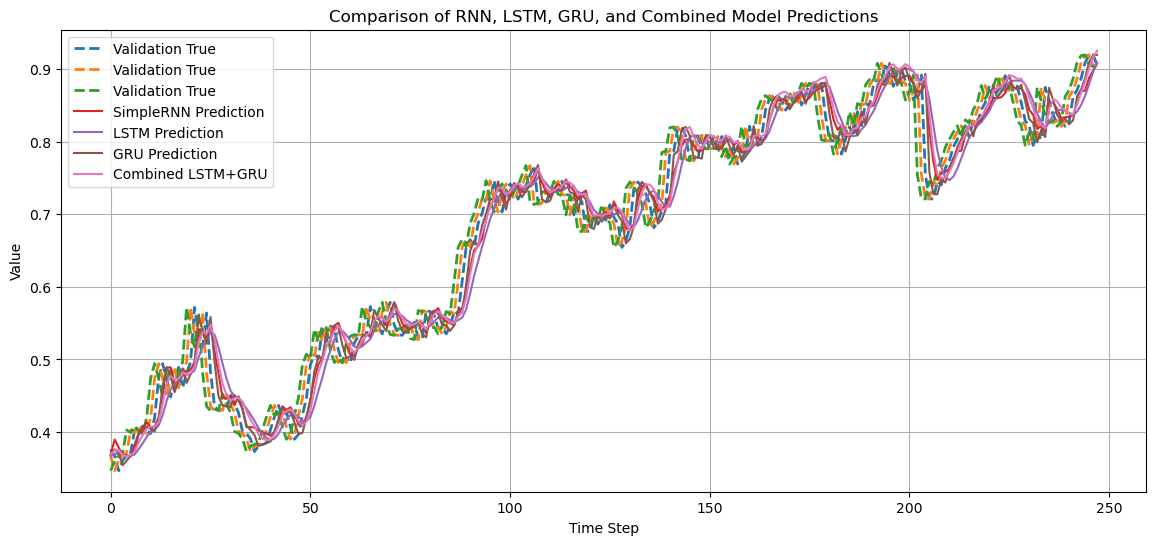

In [17]:

plt.figure(figsize=(14, 6))
plt.plot(y_val, label='Validation True', linestyle='--', linewidth=2)
plt.plot(rnn_val_pred, label='SimpleRNN Prediction')
plt.plot(lstm_val_pred, label='LSTM Prediction')
plt.plot(gru_val_pred, label='GRU Prediction')
plt.plot(combined_val_pred, label='Combined LSTM+GRU')
plt.legend()
plt.title("Comparison of RNN, LSTM, GRU, and Combined Model Predictions")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.show()
